# **Apple Stock Price Prediction**

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


sns.set_style('darkgrid')

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

In [3]:
path = "AAPL_2006-01-01_to_2018-01-01.csv"
df = pd.read_csv(path)
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [4]:
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Name       object
dtype: object

In [5]:
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date" ,inplace = True)
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


## EDA

In [6]:
df.shape

(3019, 6)

In [7]:
# Checking for missing values and duplicates
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['Missing#'] = df.isna().sum()
    summary_df['Duplicates'] = df.duplicated().sum()
    summary_df['Unique'] = df.nunique().values
    summary_df['Count'] = df.count().values
    return summary_df

summary(df).style.background_gradient(cmap='Blues')

,dtypes,Missing#,Duplicates,Unique,Count
Open,float64,0,0,2630,3019
High,float64,0,0,2579,3019
Low,float64,0,0,2575,3019
Close,float64,0,0,2579,3019
Volume,int64,0,0,3019,3019
Name,object,0,0,1,3019


In [8]:
df.drop(['Name'], axis =1, inplace = True)

In [9]:
df.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,64.673309,65.256833,64.033445,64.662892,1.311457e+08
std,44.524927,44.811772,44.230829,44.536448,1.018560e+08
min,7.390000,7.560000,7.170000,7.240000,1.147592e+07
25%,23.425000,23.805000,23.015000,23.420000,5.292889e+07
50%,57.860000,58.460000,57.320000,57.920000,1.066271e+08
75%,99.165000,100.275000,98.385000,99.480000,1.798977e+08
max,175.110000,177.200000,174.860000,176.420000,8.432640e+08


In [10]:
print(df.columns.tolist())

['Open', 'High', 'Low', 'Close', 'Volume']


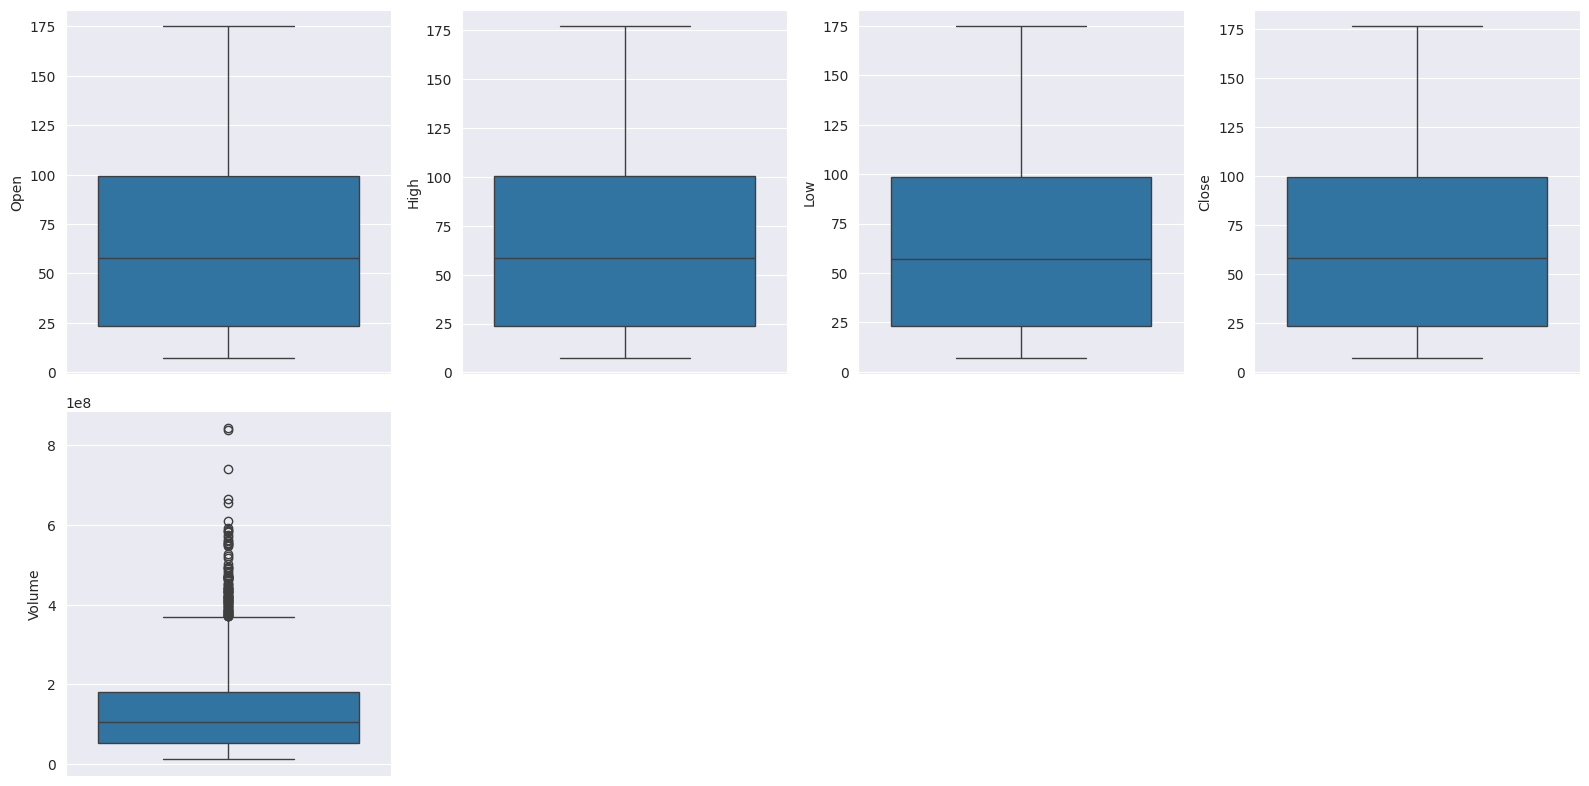

In [11]:
# boxplots of numerical features for outlier detection
num_cols =df[['Open', 'High', 'Low', 'Close', 'Volume']]
def box(df):
    fig = plt.figure(figsize=(16,16))
    for i in range(len(num_cols.columns)):
        fig.add_subplot(4, 4, i+1)
        sns.boxplot(y=num_cols.iloc[:,i])
    plt.tight_layout()
    plt.show()
box(num_cols)

<Axes: title={'center': 'Close price'}, xlabel='Date', ylabel='Close price'>

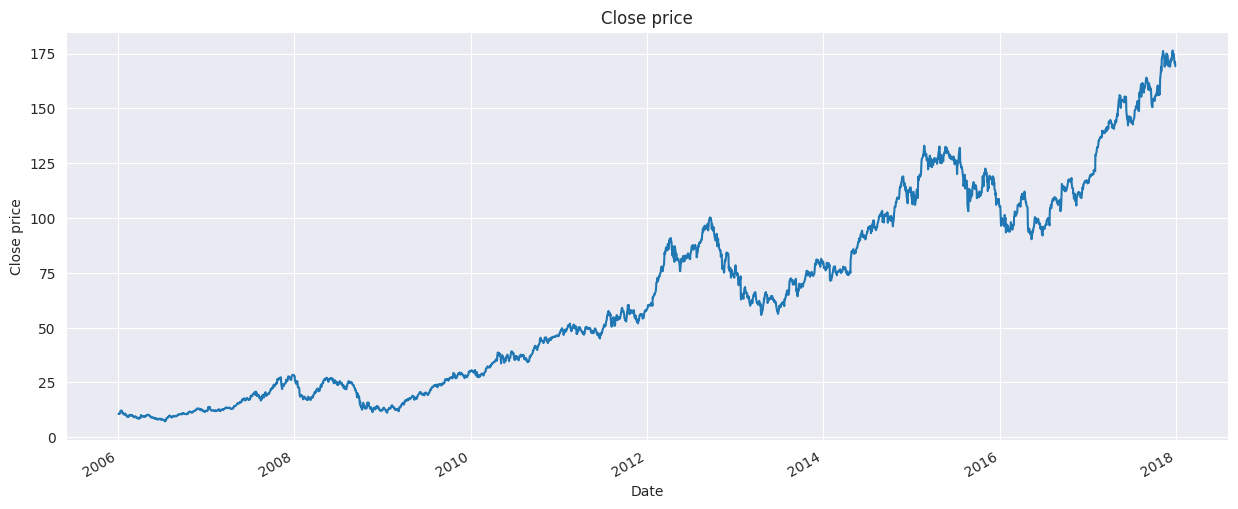

In [12]:
# Visualizing Close price
fig, ax = plt.subplots(figsize=(15,6))
df["Close"].plot(xlabel="Date", ylabel="Close price", title="Close price",ax=ax)


In [13]:
# Create a new dataframe with only the 'Close column
df_close = df[['Close']]

In [14]:
# define training and testing sets
tstart = 2006
tend = 2013
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", 'Close']
    test = dataset.loc[f"{tend+1}":, 'Close']
    return train, test

def train_test_split_values(dataset, tstart, tend):
    train, test =  train_test_split(dataset, tstart, tend)
    return train.values, test.values

training_set, test_set = train_test_split_values(df_close, tstart, tend)

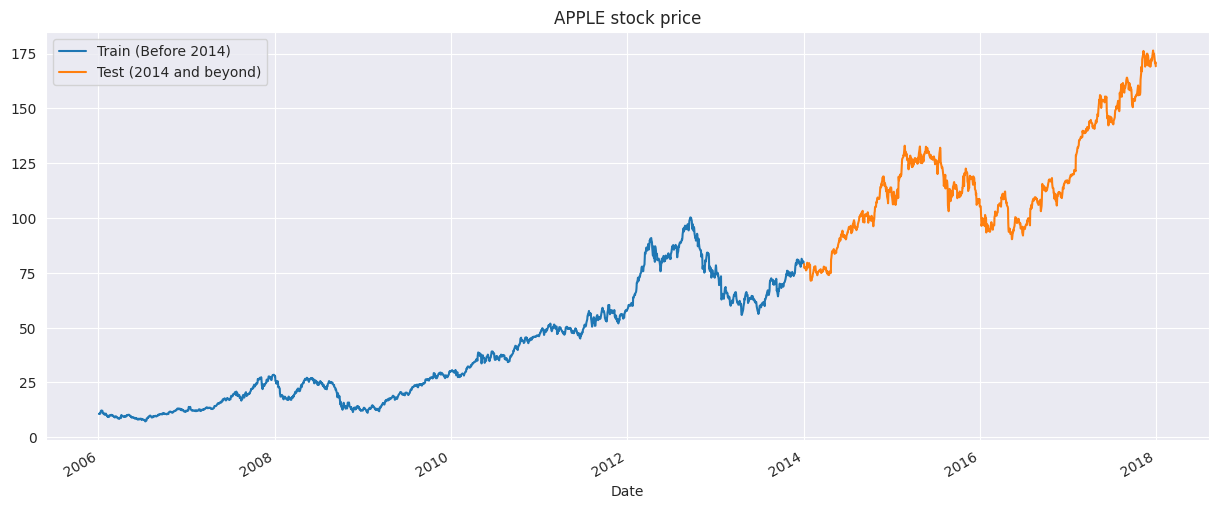

In [15]:
# Visualize training and testing data
def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", 'Close'].plot(figsize=(15, 6), legend=True)
    dataset.loc[f"{tend+1}":, 'Close'].plot(figsize=(15, 6), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("APPLE stock price")
    plt.show()

train_test_plot(df_close,tstart,tend)

In [16]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [17]:
# Split the training data into x_train and y_train data sets
'''define a function split_sequence that takes two prameters,
                    `sequence` which represent the input time series data,
                            and `window` which represent the size of sequnce window to split the data'''
def split_sequence(sequence, window):
    X, y = list(), list()            # initialize empty lists, X and y to store the input and the target respectively
    for i in range(len(sequence)):   # this loop iterates over the lenght of the input sequence
        end_ix = i + window          # determine the sequence End Index
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)    # Convert the x_train and y_train to numpy arrays

window_size = 60
features = 1

X_train, y_train = split_sequence(training_set_scaled, window_size)

In [18]:
# Reshape the data
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [19]:
# Split the test data into x_test and y_test data sets
inputs = df_close[len(df_close) - len(test_set) - window_size :].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [20]:
X_test, y_test = split_sequence(inputs, window_size)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

## LTSM

In [21]:
# create LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(window_size, features)))
model_lstm.add(Dense(25))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 25)                3150      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 66676 (260.45 KB)
Trainable params: 66676 (260.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# Fit the model
model_lstm.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
61/61 [==============================] - 13s 128ms/step - loss: 0.0102
Epoch 2/15
61/61 [==============================] - 5s 75ms/step - loss: 3.0841e-04
Epoch 3/15
61/61 [==============================] - 3s 56ms/step - loss: 3.2498e-04
Epoch 4/15
61/61 [==============================] - 3s 57ms/step - loss: 2.9396e-04
Epoch 5/15
61/61 [==============================] - 5s 81ms/step - loss: 2.7441e-04
Epoch 6/15
61/61 [==============================] - 4s 57ms/step - loss: 2.6692e-04
Epoch 7/15
61/61 [==============================] - 3s 57ms/step - loss: 2.7429e-04
Epoch 8/15
61/61 [==============================] - 5s 82ms/step - loss: 2.4600e-04
Epoch 9/15
61/61 [==============================] - 3s 57ms/step - loss: 2.3668e-04
Epoch 10/15
61/61 [==============================] - 3s 57ms/step - loss: 2.4729e-04
Epoch 11/15
61/61 [==============================] - 4s 73ms/step - loss: 2.3236e-04
Epoch 12/15
61/61 [==============================] - 4s 63ms/step - loss: 2.

In [23]:
# Make predictions
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y_test = sc.inverse_transform(y_test)

32/32 [==============================] - 1s 25ms/step


In [24]:
# View results
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

# Calculate RMSE
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

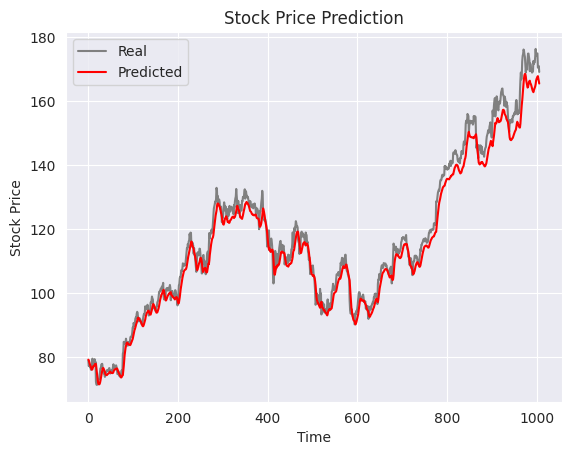

In [25]:
plot_predictions(y_test,predicted_stock_price)

In [26]:
return_rmse(y_test,predicted_stock_price)

The root mean squared error is 3.84.


## GRU

In [27]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(window_size, features)))
model_gru.add(Dense(units=1))

model_gru.compile(optimizer="adam", loss="mse")

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense_2 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48126 (187.99 KB)
Trainable params: 48126 (187.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
model_gru.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
61/61 [==============================] - 4s 42ms/step - loss: 0.0092
Epoch 2/10
61/61 [==============================] - 3s 43ms/step - loss: 1.6906e-04
Epoch 3/10
61/61 [==============================] - 5s 79ms/step - loss: 1.5764e-04
Epoch 4/10
61/61 [==============================] - 3s 45ms/step - loss: 1.5882e-04
Epoch 5/10
61/61 [==============================] - 3s 42ms/step - loss: 1.5497e-04
Epoch 6/10
61/61 [==============================] - 3s 41ms/step - loss: 1.4291e-04
Epoch 7/10
61/61 [==============================] - 3s 41ms/step - loss: 1.3974e-04
Epoch 8/10
61/61 [==============================] - 5s 75ms/step - loss: 1.3022e-04
Epoch 9/10
61/61 [==============================] - 3s 41ms/step - loss: 1.2823e-04
Epoch 10/10
61/61 [==============================] - 3s 41ms/step - loss: 1.3176e-04


In [29]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

32/32 [==============================] - 1s 15ms/step


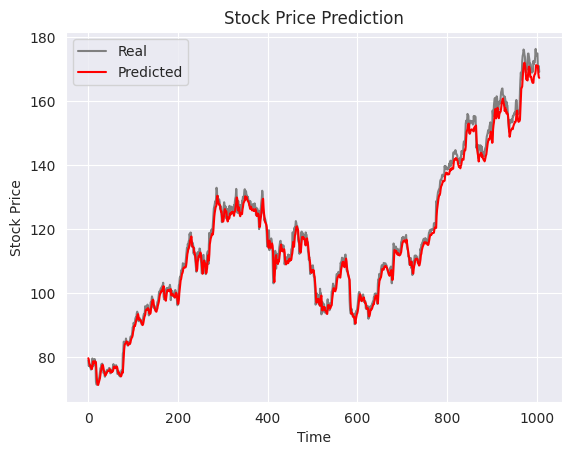

In [31]:
plot_predictions(y_test, GRU_predicted_stock_price)

In [30]:
return_rmse(y_test,GRU_predicted_stock_price)

The root mean squared error is 2.41.
